In [9]:
import os
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
train_data_files = ['cross', 'dead', 'left', 'right', 'straight', 'threeway']
# NUM_CLASSES = 6
NUM_CLASSES = len(train_data_files)

epochs = 120
batch_size = 100

RATIO_DROP_OUT1 = 0.25
RATIO_DROP_OUT2 = 0.50
unit_param = np.arange(50, LIMIT_UNIT_NUM, INCREMENT_UNIT_NUM)



In [11]:
def split_data():
    files = os.listdir('./data')
    X = []
    Y = []
    all_data_set = []
    labels = []


    for i in range(NUM_CLASSES):
        try:
            # header = 列名
            file_name = "./data/" + files[i]
            data_set = pd.read_csv(file_name, header=None)
            all_data_set.append(data_set)
        
            num_data_set = len(data_set)
            print(num_data_set)

            # one_hot_vectorを作りラベルとして追加
            tmp = np.zeros((num_data_set, NUM_CLASSES))
            tmp[:, i] = 1
            labels.append(tmp)
        except pd.io.common.EmptyDataError:
            print("ERROR: {} is empty".format(file_name))

    X = pd.concat(all_data_set)
    X = X.fillna(0)
    Y = np.concatenate(labels, axis=0)

#    _, DIM_input_data = data_set.shape

    X_train, X_validation_and_test, Y_train, Y_validation_and_test = train_test_split(X, Y,train_size=0.6, test_size=0.4)
    X_validation, X_test, Y_validation, Y_test = train_test_split(X_validation_and_test, Y_validation_and_test, train_size=0.5, test_size=0.5)

    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

In [5]:
def plt_result(epochs, history):
    plt.plot(range(1, epochs+1), history.history['acc'], label="training")
    plt.plot(range(1, epochs+1), history.history['val_acc'], label="validation")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [64]:
def param():
    ret = {
        'out_dim':[10, 100],
        'optimizer':["adam", "adagrad"]
    }


    return ret

In [52]:
def make_model(activation="relu", optimizer="adam", out_dim=100, DIM_input_data=726):

    model = Sequential()
    model.add(Dense(out_dim, input_dim=DIM_input_data, activation=activation))
    model.add(Dense(out_dim, activation=activation))   
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [55]:
if __name__ == "__main__":
    X_train, X_validation, X_test, Y_train, Y_validation, Y_test = split_data()
    _, DIM_input_data = X_train.shape


164
285
112
ERROR: ./data/right.csv is empty
3798
696


In [ ]:
if __name__ == "__main__":
    

In [72]:
import numpy as np
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier


# import data and divided it into training and test purposes
X_train, X_validation, X_test, Y_train, Y_validation, Y_test = split_data()


# Define model for iris classification
def make_model(activation="relu", optimizer="adam", out_dim=100):
    model = Sequential()
    model.add(Dense(out_dim, input_dim=726, activation=activation))
    model.add(Dense(out_dim, activation=activation))   
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define options for parameters
out_dim = [100, 200]


# Retrieve model and parameter into GridSearchCV
model = KerasClassifier(build_fn=make_model, verbose=0)
param_grid = dict(out_dim=out_dim)
grid = GridSearchCV(estimator=model, param_grid=param_grid)


# Run grid search
grid_result = grid.fit(X_train, Y_train)


# Get the best score and the optimized mode
print (grid_result.best_score_)
print (grid_result.best_params_)

# Now see the optimized model
model = make_model(out_dim=grid_result.best_params_['out_dim'])
model.summary()

164
285
112
ERROR: ./data/right.csv is empty
3798
696
0.7790966040813762
{'out_dim': 200}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_252 (Dense)            (None, 200)               145400    
_________________________________________________________________
dense_253 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_254 (Dense)            (None, 6)                 1206      
Total params: 186,806
Trainable params: 186,806
Non-trainable params: 0
_________________________________________________________________


In [3]:
model = Sequential()
files = os.listdir('./data')
X = []
Y = []
all_data_set = []
labels = []


for i in range(NUM_CLASSES):
    try:
        # header = 列名
        file_name = "./data/" + files[i]
        data_set = pd.read_csv(file_name, header=None)
        all_data_set.append(data_set)
        
        num_data_set = len(data_set)
        print(num_data_set)

        # one_hot_vectorを作りラベルとして追加
        tmp = np.zeros((num_data_set, NUM_CLASSES))
        tmp[:, i] = 1
        labels.append(tmp)
    except pd.io.common.EmptyDataError:
        print("ERROR: {} is empty".format(file_name))

X = pd.concat(all_data_set)
X = X.fillna(0)
Y = np.concatenate(labels, axis=0)

_, DIM_input_data = data_set.shape

121
119
ERROR: ./data/left.csv is empty
ERROR: ./data/right.csv is empty
1089
482


In [8]:
X_train, X_validation_and_test, Y_train, Y_validation_and_test = train_test_split(X, Y,train_size=0.6)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_validation_and_test, Y_validation_and_test, train_size=0.5)

NameError: name 'X' is not defined

In [ ]:
MAX_MID_LAYER = 4
MAX_UNIT_NUM = 500
MAX_acc = 0

while Hidden_layer1 <= LIMIT_UNIT_NUM:
    Hidden_layer1 += INCREMENT_UNIT_NUM
    






model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT1))

for j in range(MAX_MID_LAYER):
    model.add(Dense(DIM_HIDDEN2, activation='relu'))
    if j == MAX_MID_LAYER:
        model.add(Dropout(RATIO_DROP_OUT2))
    else:
        model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))
    

In [5]:
MAX_MID_LAYER = 4
MAX_UNIT_NUM = 500
MAX_acc = 0

DIM_HIDDEN1 = 100
DIM_HIDDEN2 = 100


model.add(Dense(DIM_HIDDEN1, input_dim = DIM_input_data, activation='relu'))
model.add(Dropout(RATIO_DROP_OUT1))

for j in range(MAX_MID_LAYER):
    model.add(Dense(DIM_HIDDEN2, activation='relu'))
    if j == MAX_MID_LAYER:
        model.add(Dropout(RATIO_DROP_OUT2))
    else:
        model.add(Dropout(RATIO_DROP_OUT1))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_validation, Y_validation))
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


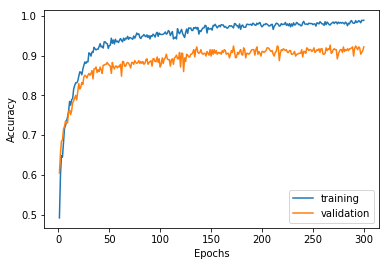

In [6]:
plt.plot(range(1, epochs+1), history.history['acc'], label="training")
plt.plot(range(1, epochs+1), history.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()